In [66]:
import pandas as pd
import numpy as np

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt

import seaborn as sns
%matplotlib inline

import warnings; warnings.simplefilter('ignore')
sns.set()

sample_set = pd.read_excel(r'C:\STUDY\SkillFactory\Module_6\kaggle\auto_dataset_short.xlsx',sheet_name='test')
auto_data = pd.read_excel(r'C:\STUDY\SkillFactory\Module_6\kaggle\auto_dataset_short.xlsx',sheet_name='auto')
submission_set = sample_set['sell_id'].copy()  # оставляем id's для файла submission

In [67]:
# функция приводит в порядок дата-сеты
def putting_order(df):
    # оставляем только название кузова без признака кол-ва дверей и пр
    df['bodyType'] = df['bodyType'].apply(lambda row: row.split()[0])

    # переводим объем двигателя в int
    df['engineDisplacement'] = df['engineDisplacement'].apply(lambda row: float(0.0) if row.split()[0] == 'LTR' else float(
            row.split()[0]))

    # перводим мощность двигателя в int
    df['enginePower'] = df['enginePower'].apply(lambda row: int(row.split(' ')[0]))

    # извлекаем год объявления  считаем возраст авто
    # df['unix_year'] = pd.to_datetime(df['parsing_unixtime'].astype(int), unit='s').dt.year
        
    # переводим в int количество владельцев автомобиляю Думаю тут есть приоритетность
    df['Владельцы'] = df['Владельцы'].apply(lambda row: int(row[0]))  # кол-во владельцев в int

    # кодируем привод. Наивысший приоритет у полного привода, потом передний и потом задний
    drive_weels = {'полный': 3, 'передний': 2, 'задний': 1}
    df['Привод'] = df['Привод'].map(drive_weels)

    # кодируем трансмиссию. Считаю, есть приоритетность для покупателя
    # вариатор -4, автоматичесукая - 3, роботизированная - 2, механическая - 1
    transmission = {'вариатор': 4, 'автоматическая': 3, 'роботизированная': 2, 'механическая': 1}
    df['vehicleTransmission'] = df['vehicleTransmission'].map(transmission)

    # подрежем milage к более укрупненным цифрам, до 10 000
    # df['mileage'] = df['mileage'].apply(lambda row: int(round(row, -4)))

    # просто приводим тип данных к единому формату
    df[['modelDate', 'productionDate']] = df[['modelDate', 'productionDate']].astype(int)

    df['equipment_list'] = list(map(lambda item: item.count(':') if isinstance(item, str) else 0, df['equipment_dict']))

    return df

In [68]:
# функция удаяет ненужны колонки
def remove_useless(df):
    columns_to_delete = ["car_url", "image", "complectation_dict", "sell_id", "Состояние", "priceCurrency", 
                         "Таможня", "model_info", "description", "equipment_dict",
                         "super_gen", 'parsing_unixtime', 'name', 'vehicleConfiguration', 'model_name']
    df.drop(columns=columns_to_delete, inplace=True)

    return df

In [69]:
# записи без цены не несут для нас ценности
auto_data.dropna(subset=["price"], inplace=True)

# оставляю только бренды, которые есть в target data-set
sample_brands = sample_set.brand.unique()
# тут некрасиво, hard-coding в split('-') под конкретный brand Mercedes-Benz
auto_data.brand = auto_data.brand.apply(lambda row: row.split('-')[0].upper())
auto_data = auto_data[auto_data['brand'].isin(sample_brands)]

# удалим 'Владение' - слищком много пропусков, под 70% всего объема
#auto_data.drop(['Владение'], axis=1, inplace=True)
#sample_set.drop(['Владение'], axis=1, inplace=True)

# предварительно проверил количество строк с пропусками. Их были едницы на сете в 88 тыс строк
auto_data.dropna(inplace=True)

# выравниваем признаки в двух дата-сетах
auto_data = putting_order(auto_data)
sample_set = putting_order(sample_set)

In [70]:
def bin_labeling(data_set, columns_list):
    for column in columns_list:
        data_set[column] = LabelEncoder().fit_transform(data_set[column])
    return data_set

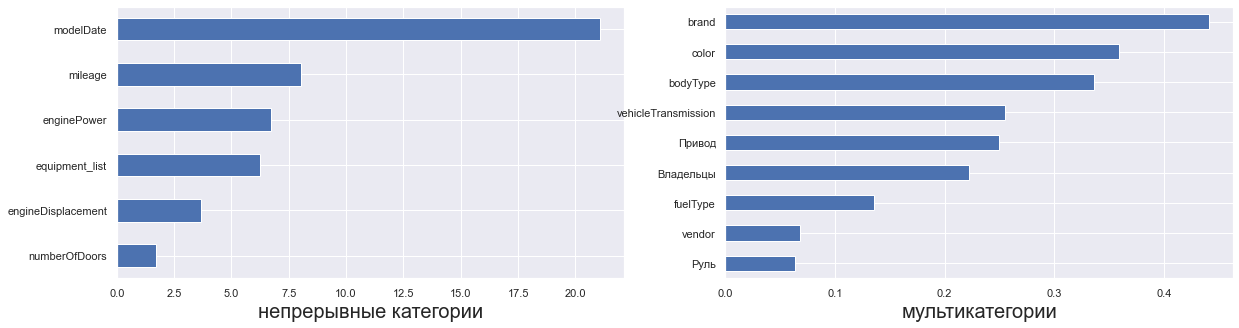

In [71]:
# оценка значимости  признаков
fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

# это количественные признаки 
num_columns = ['enginePower', 'mileage', 'engineDisplacement', 'modelDate', 'numberOfDoors', 'equipment_list' ]
imp_num = pd.Series(f_classif(auto_data[num_columns], auto_data['price'])[0], index = num_columns)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh', ax=ax1)
ax1.set_xlabel('непрерывные категории', fontsize=20)

# это мультикатегории
cat_columns= ['bodyType', 'brand', 'color', 'fuelType', 'Привод', 'Руль', 'vehicleTransmission', 'vendor', 'Владельцы']
auto_data = bin_labeling(auto_data, cat_columns)
imp_cat = pd.Series(mutual_info_classif(auto_data[cat_columns], auto_data['price'],
                                     discrete_features =True), index = cat_columns)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh', ax=ax2)
ax2.set_xlabel('мультикатегории', fontsize=20)

plt.show()

In [72]:
# удаляем лишние признаки 
auto_data = remove_useless(auto_data)
sample_set = remove_useless(sample_set)

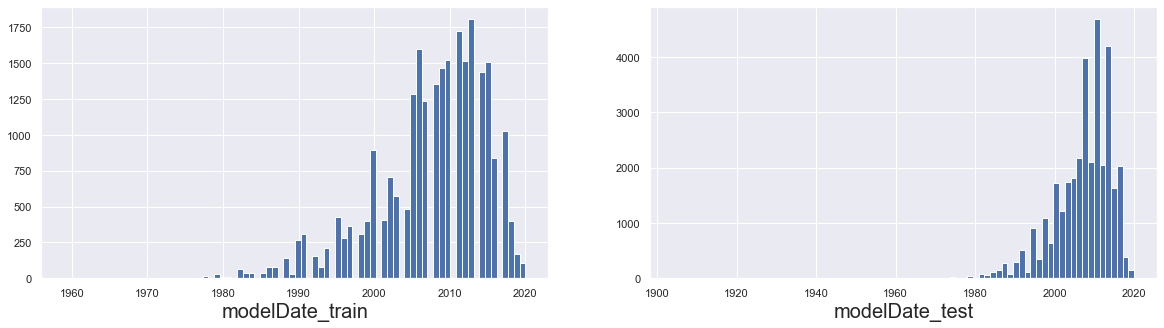

In [73]:
# рассмотрим распределение признака modelDate 
fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
labels = [0,1]

ax1.hist(auto_data['modelDate'], bins=80)
ax1.set_xlabel('modelDate_train', fontsize=20)
ax2.hist(sample_set['modelDate'], bins=80)
ax2.set_xlabel('modelDate_test', fontsize=20)

plt.show()

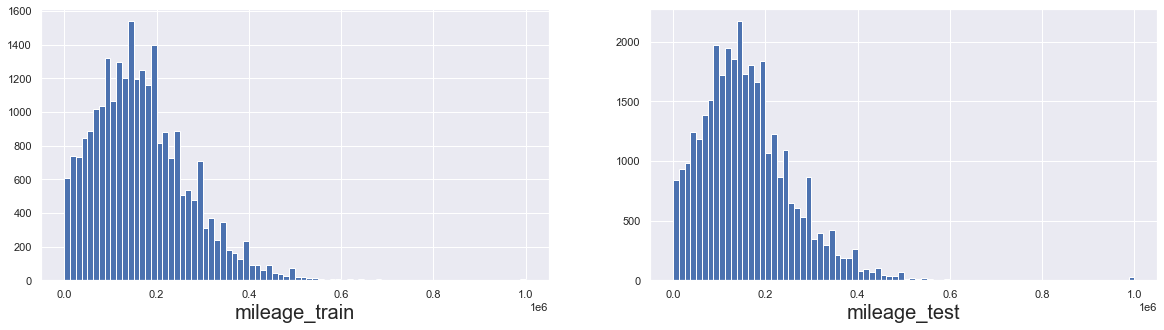

In [74]:
# рассмотрим распределение признака modelDate 
fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
labels = [0,1]

ax1.hist(auto_data['mileage'], bins=80)
ax1.set_xlabel('mileage_train', fontsize=20)
ax2.hist(sample_set['mileage'], bins=80)
ax2.set_xlabel('mileage_test', fontsize=20)

plt.show()

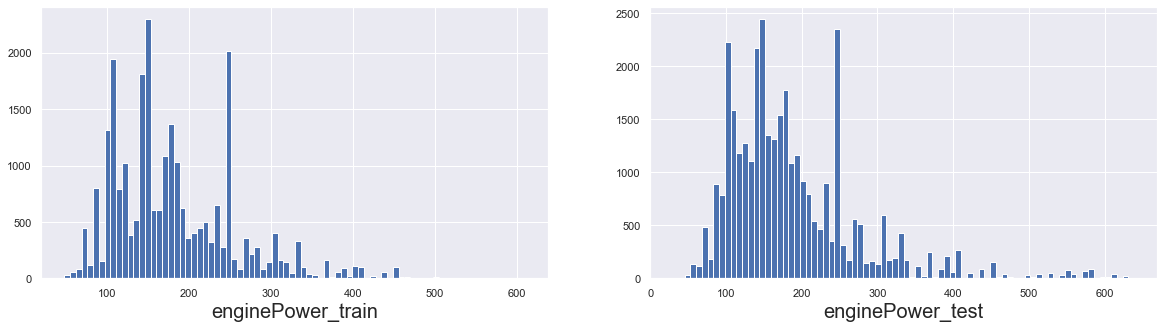

In [75]:
# рассмотрим распределение признака enginePower
fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
labels = [0,1]

ax1.hist(auto_data['enginePower'], bins=80)
ax1.set_xlabel('enginePower_train', fontsize=20)
ax2.hist(sample_set['enginePower'], bins=80)
ax2.set_xlabel('enginePower_test', fontsize=20)

plt.show()

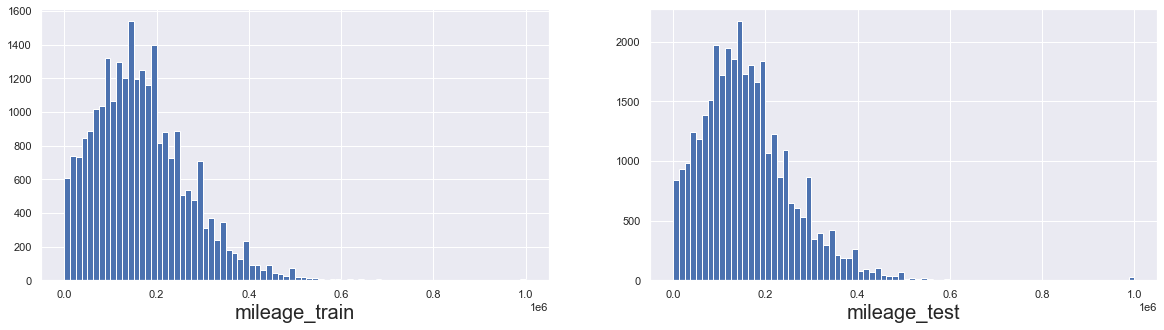

In [76]:
# рассмотрим распределение признака milage
fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
labels = [0,1]

ax1.hist(auto_data['mileage'], bins=80)
ax1.set_xlabel('mileage_train', fontsize=20)
ax2.hist(sample_set['mileage'], bins=80)
ax2.set_xlabel('mileage_test', fontsize=20)

plt.show()

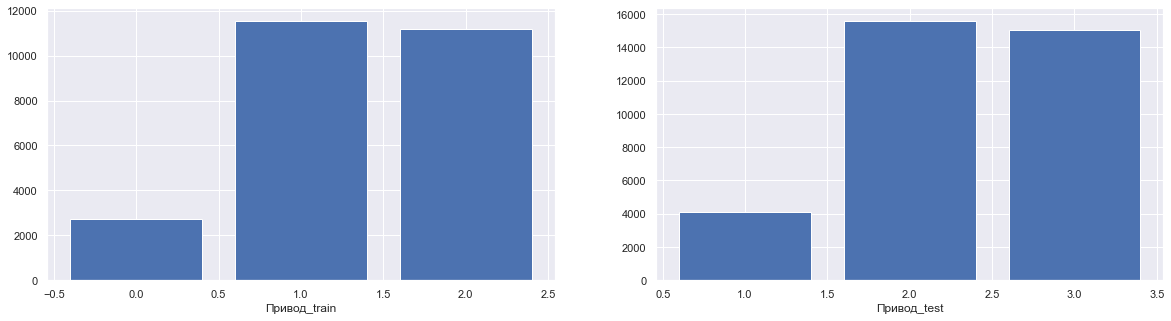

In [77]:
# рассмотрим распределение категориальных признаков 
fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)


ax1.bar(x = auto_data['Привод'].unique(), height = auto_data['Привод'].dropna().value_counts())
ax1.set_xlabel('Привод_train')
ax2.bar(x = sample_set['Привод'].unique(), height = sample_set['Привод'].value_counts())
ax2.set_xlabel('Привод_test')

plt.show()

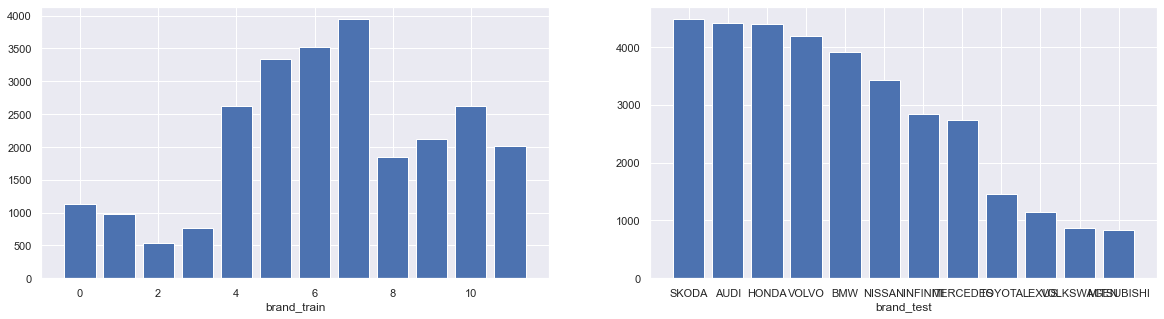

In [81]:
# рассмотрим распределение по брендам 
fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)


ax1.bar(x = auto_data['brand'].unique(), height = auto_data['brand'].value_counts())
ax1.set_xlabel('brand_train')
ax2.bar(x = sample_set['brand'].unique(), height = sample_set['brand'].value_counts())
ax2.set_xlabel('brand_test')

plt.show()


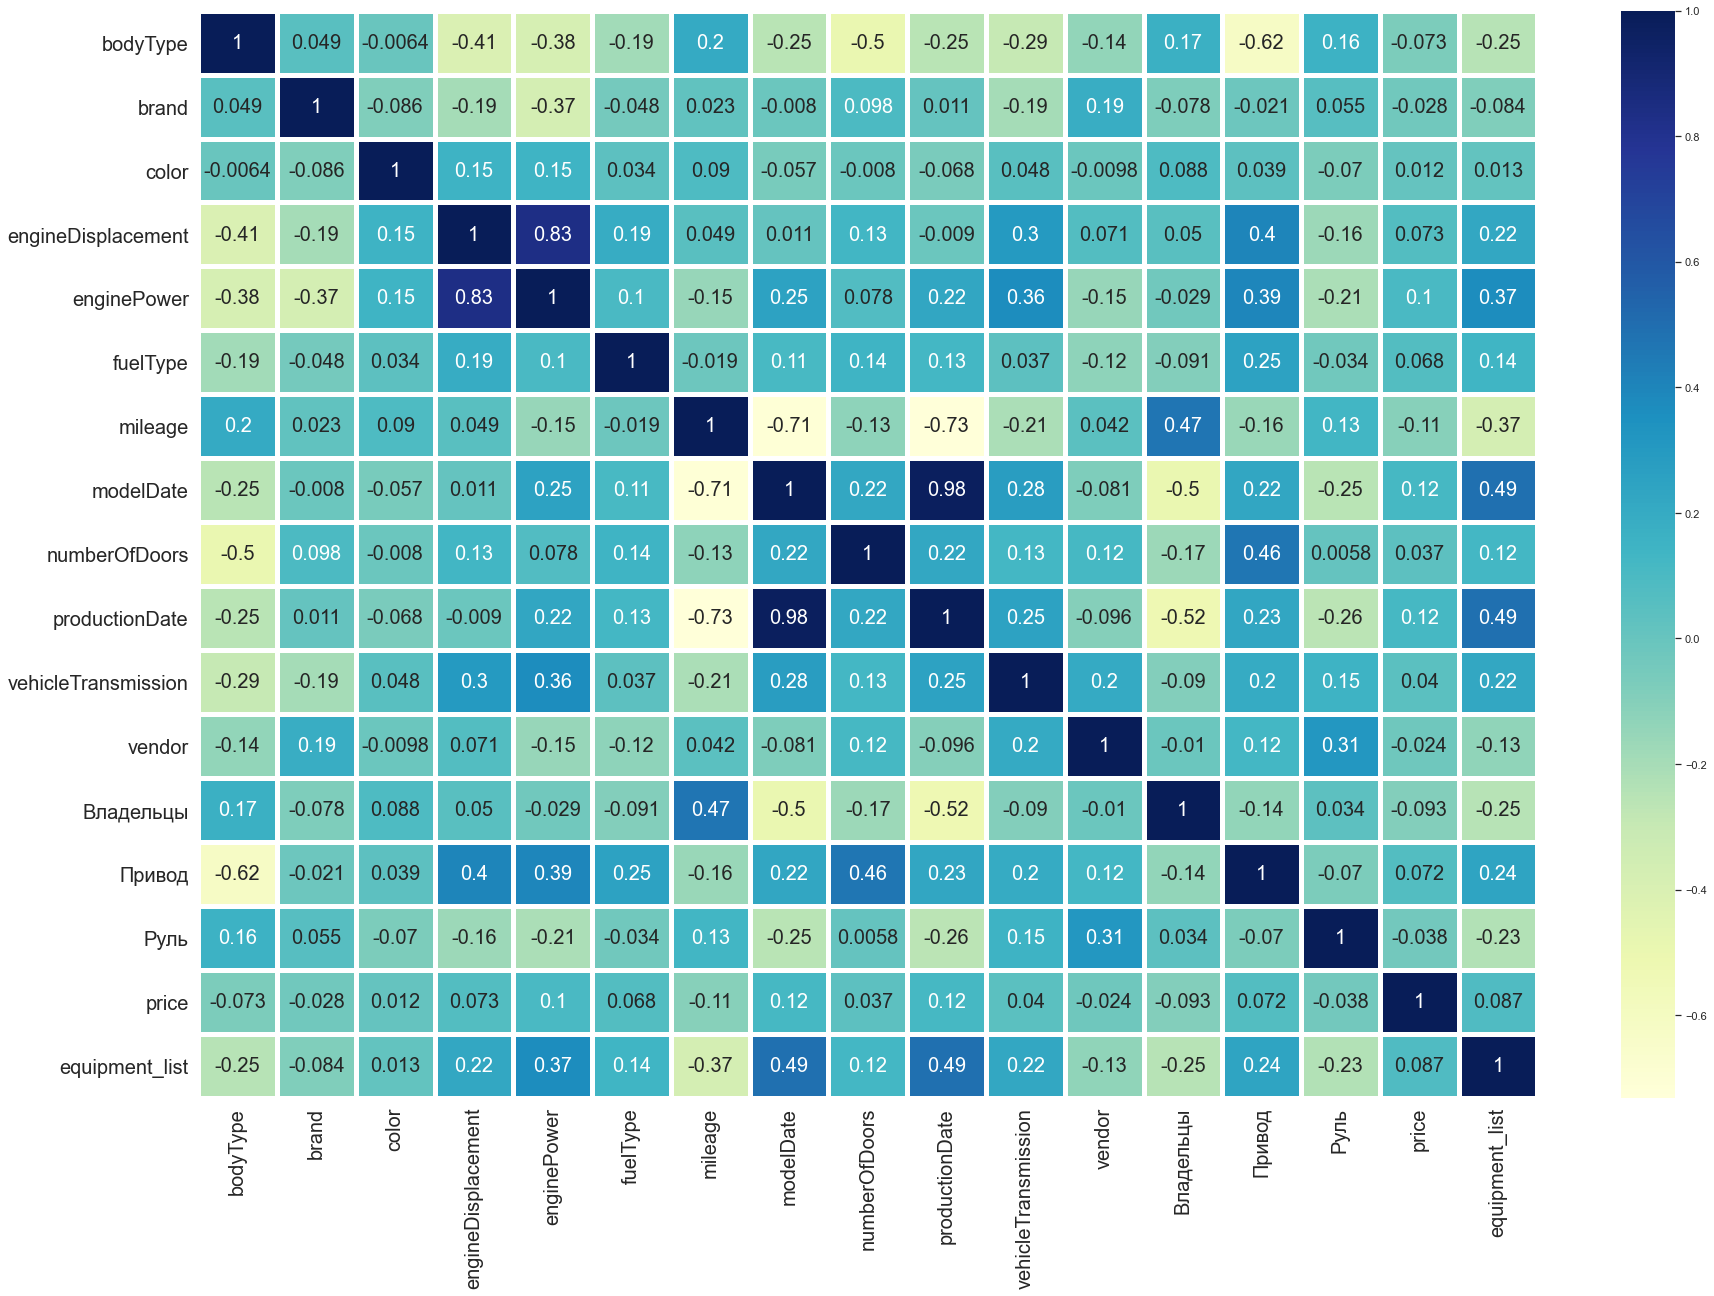

In [84]:
# посмотрим матрицу корреляции признаков
fig, ax = plt.subplots(figsize=(30,20)) 
sns.heatmap(auto_data.corr(method = 'pearson'),ax=ax, 
            annot=True, cmap='YlGnBu', 
            linewidths=5, annot_kws={"fontsize":20})
plt.yticks(rotation=0,fontsize = 20)
plt.xticks(rotation=90,fontsize = 20)
plt.show()